In [6]:
import copy
import pandas
import time

ACCELERATION_NOISE_THRESHOLD_POSITIVE = 0.9
ACCELERATION_NOISE_THRESHOLD_NEGATIVE = -1.5

df = pandas.read_csv('initial_testdata/Raw Data.csv')

<Axes: xlabel='Time (s)'>

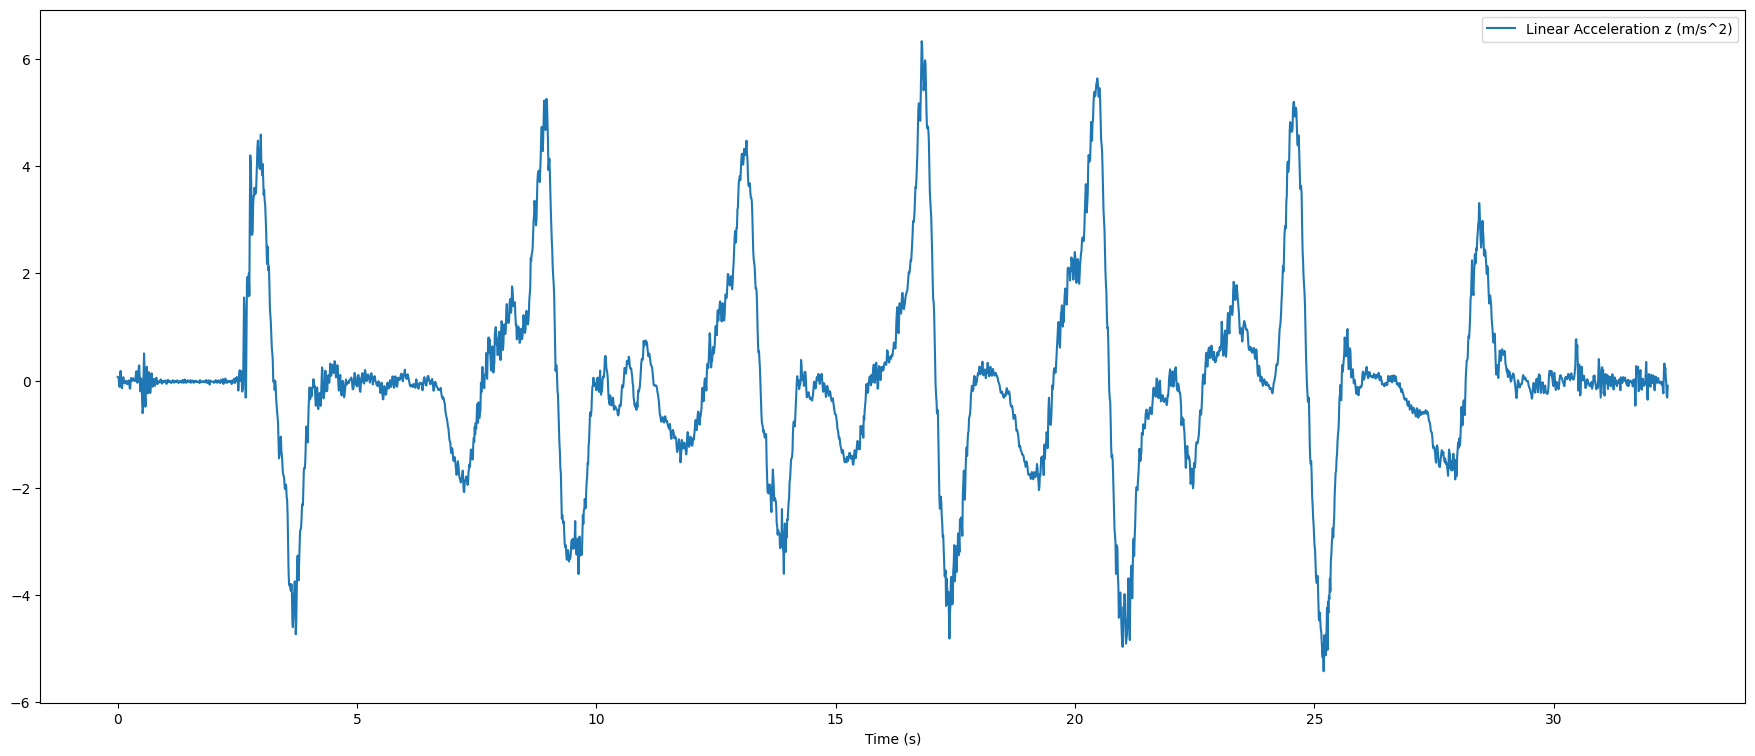

In [7]:
df.plot.line(x="Time (s)", y="Linear Acceleration z (m/s^2)", figsize=(22, 9))

### Removing noise - too high rate of change of acceleration changed to 0

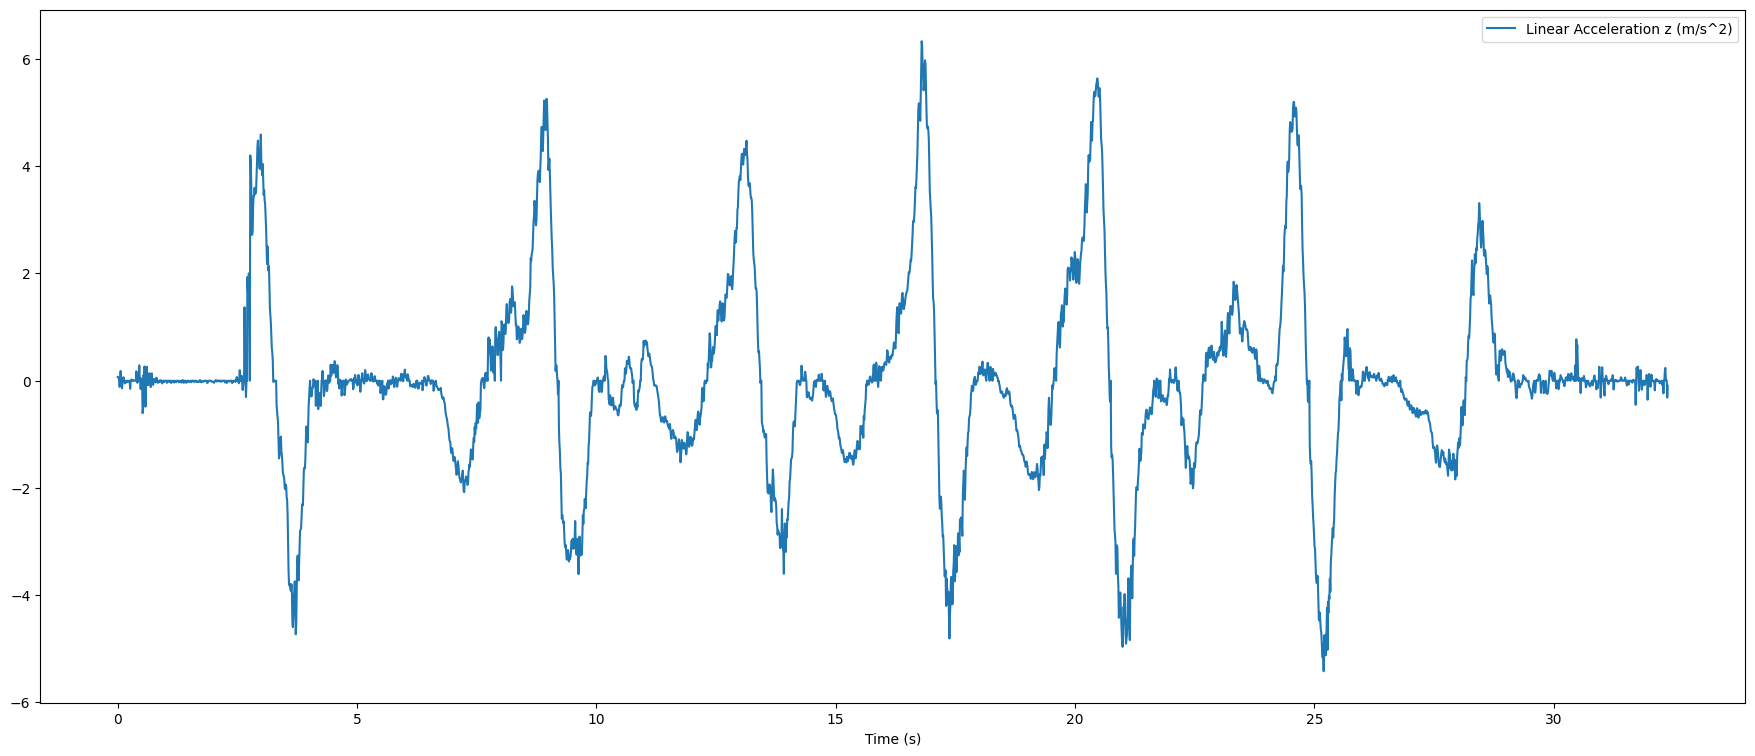

In [8]:
def filter_noise(dataframe):
  new_df = copy.deepcopy(dataframe)
  changes = new_df.pct_change()["Linear Acceleration z (m/s^2)"]
  for i, change in changes.items():
    if change > ACCELERATION_NOISE_THRESHOLD_POSITIVE or change < ACCELERATION_NOISE_THRESHOLD_NEGATIVE:
      new_df["Linear Acceleration z (m/s^2)"][i] = 0.0
  new_df.plot.line(x="Time (s)", y="Linear Acceleration z (m/s^2)", figsize=(22, 9))
  return new_df

filtered_df = filter_noise(df)

### Calculating velocity and distance from z-axis acceleration and timesteps

In [16]:
def get_velocity(acceleration: float, V0: float, delta_t: float):
  # a = (V1-V0) / t
  # V1 = a*t + V0
  return acceleration * delta_t + V0

def get_distance(delta_V: float, delta_t: float):
  # V = s/t
  # s = V*t
  return delta_V * delta_t

def get_energy_spent(mass: float, distance: float, acceleration: float):
  # A = F*s
  # F = m*a
  return mass * acceleration * distance

mass = 5
previous_time = 0.0
previous_velocity = 0.0
total_distance = 0.0
total_energy = 0.0
velocity_vec = [[]]
distance_vec = [[]]
energy_vec = [[]]

start_time = time.time()
for index, row in df.iterrows():
  timestep = row["Time (s)"] - previous_time

  velocity = get_velocity(row["Linear Acceleration z (m/s^2)"], previous_velocity, timestep)
  velocity_vec.append([row["Time (s)"], velocity])

  distance_step = abs(get_distance(velocity, timestep))
  total_distance += distance_step
  distance_vec.append([row["Time (s)"], total_distance])

  energy_step = abs(get_energy_spent(mass, distance_step, row["Linear Acceleration z (m/s^2)"]))
  total_energy += energy_step
  energy_vec.append([row["Time (s)"], total_energy])

  previous_velocity = velocity
  previous_time = row["Time (s)"]
print("Time spent: ", time.time() - start_time)

Time spent:  0.10654163360595703


### Plotting

Distance is (m):  19.952919557743094
Energy is (J):  124.60287901148602


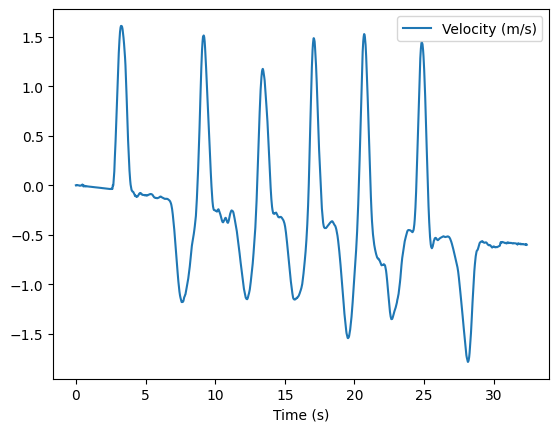

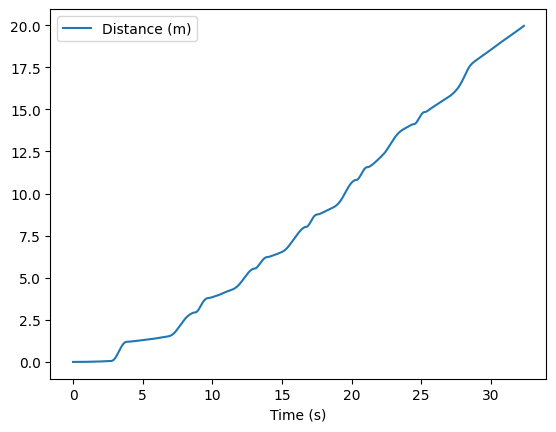

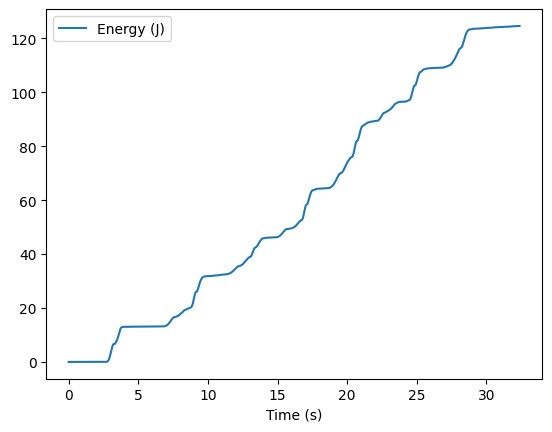

In [17]:
df_velocity = pandas.DataFrame(velocity_vec, columns=["Time (s)", "Velocity (m/s)"])
df_velocity.plot.line(x="Time (s)", y="Velocity (m/s)")
df_distance = pandas.DataFrame(distance_vec, columns=["Time (s)", "Distance (m)"])
df_distance.plot.line(x="Time (s)", y="Distance (m)")
df_energy = pandas.DataFrame(energy_vec, columns=["Time (s)", "Energy (J)"])
df_energy.plot.line(x="Time (s)", y="Energy (J)")
print("Distance is (m): ", total_distance)
print("Energy is (J): ", total_energy)

## 2nd way of calculating values

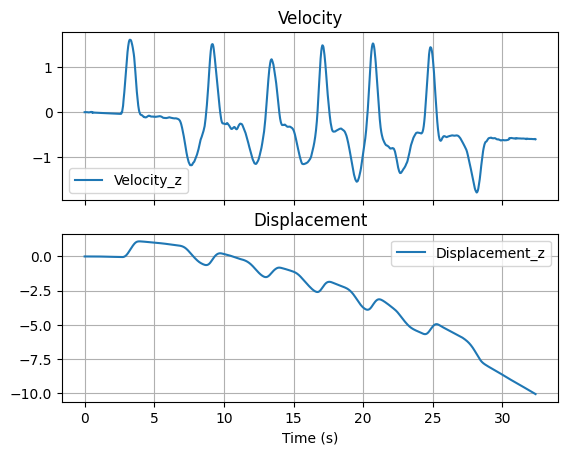

In [11]:
# get the time and z-axis acceleration data
t = df.loc[:, "Time (s)"]
az = df.loc[:, "Linear Acceleration z (m/s^2)"]
start_time = time.time()
# integrate the acceleration twice to obtain displacement
vz = az.cumsum() * (t.iloc[1] - t.iloc[0])  # integrate acceleration to get velocity
sz = vz.cumsum() * (t.iloc[1] - t.iloc[0])  # integrate velocity to get displacement
df["Velocity_z"] = vz
df["Displacement_z"] = sz
# plot the displacement data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
df.plot.line(x="Time (s)", y="Velocity_z", ax=axes[0])
df.plot.line(x="Time (s)", y="Displacement_z", ax=axes[1])
axes[0].set_title("Velocity")
axes[1].set_title("Displacement")
axes[-1].set_xlabel("Time (s)")
fig.subplots_adjust(hspace=0.2)
for ax in axes:
  ax.grid()

## 3rd way of calculating values, separating upwards peaks

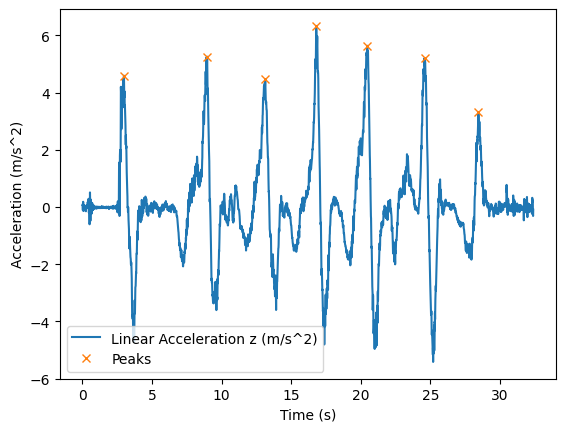

Movement 1:
Start time: 2.99s
End time: 8.96s
Displacement: -6.33m
Energy: -621.37J

Movement 2:
Start time: 8.96s
End time: 13.14s
Displacement: -4.76m
Energy: -466.12J

Movement 3:
Start time: 13.14s
End time: 16.80s
Displacement: -2.79m
Energy: -273.37J

Movement 4:
Start time: 16.80s
End time: 20.47s
Displacement: -2.45m
Energy: -239.93J

Movement 5:
Start time: 20.47s
End time: 24.57s
Displacement: -4.60m
Energy: -451.69J

Movement 6:
Start time: 24.57s
End time: 28.44s
Displacement: -4.02m
Energy: -378.02J



In [27]:
import numpy as np
from scipy.signal import find_peaks

# set some parameters for the peak detection algorithm
prominence_threshold = 2
distance_between_peaks = 300

# detect the peaks in the acceleration data
peaks, _ = find_peaks(df['Linear Acceleration z (m/s^2)'].values, prominence=prominence_threshold, distance=distance_between_peaks)

# plot the acceleration data with the detected peaks
plt.plot(df['Time (s)'], df['Linear Acceleration z (m/s^2)'], label='Linear Acceleration z (m/s^2)')
plt.plot(df['Time (s)'][peaks], df['Linear Acceleration z (m/s^2)'][peaks], 'x', label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.show()

# calculate the displacement and energy for each movement
movements = []
for i in range(len(peaks) - 1):
  # select the data for the current movement
  start_index = peaks[i]
  end_index = peaks[i+1]
  movement_data = df.loc[start_index:end_index]

  # calculate the displacement of the movement by integrating the acceleration
  dt = np.mean(np.diff(movement_data['Time (s)']))
  vz = np.cumsum(movement_data['Linear Acceleration z (m/s^2)']) * dt
  sz = np.cumsum(vz) * dt
  displacement = sz.iloc[-1]

  # calculate the energy of the movement using the work-energy principle
  mass = 10  # kg
  g = 9.81  # m/s^2
  work = mass * g * displacement
  energy = work + 0.5 * mass * (vz.iloc[-1] ** 2)

  # add the movement data and calculated values to the movements list
  movements.append({
    'start_time': movement_data['Time (s)'].iloc[0],
    'end_time': movement_data['Time (s)'].iloc[-1],
    'displacement': displacement,
    'energy': energy
  })

# print the results
for i, movement in enumerate(movements):
  print(f"Movement {i+1}:")
  print(f"Start time: {movement['start_time']:.2f}s")
  print(f"End time: {movement['end_time']:.2f}s")
  print(f"Displacement: {movement['displacement']:.2f}m")
  print(f"Energy: {movement['energy']:.2f}J")
  print()